# Exoplanet Hunting in Deep Space

In [3]:
import reservoirpy as rpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pylab

from pylab import sqrt
from reservoirpy.datasets import japanese_vowels
from reservoirpy import set_seed, verbosity
from reservoirpy.observables import nrmse, rsquare

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve

import seaborn as sns
from sklearn.metrics import confusion_matrix

Data - https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data

## 1. Understanding the Data

In [6]:
test = pd.read_csv(r'C:\Users\Fitzpatrick\Downloads\exoTest.csv')
train = pd.read_csv(r'C:\Users\Fitzpatrick\Downloads\exoTrain.csv')
train

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


Data from stars from the kepler NASA space telescope - their change in light intensity over time and a binary label - label 2 implies there is at lest one exoplanet in orbit of the star

The training set has data from 5087 stars. There is 37 confirmed exoplants in this dataset

The test set has data from 570 stars and there is 5 exoplanets to detect in this data set

### Example Plots

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 9 Text major ticklabel objects>)

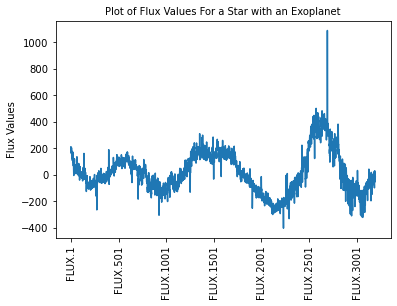

In [8]:
exampleexo = train.loc[5]
exampleexo = exampleexo.drop(['LABEL'])
exampleexo.plot()
plt.title('Plot of Flux Values For a Star with an Exoplanet',fontsize=10)
plt.ylabel('Flux Values', fontsize = 10)
plt.xticks(rotation=90)

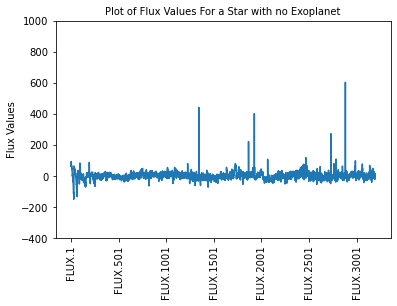

In [9]:
examplenoexo = train.loc[3480]
examplenoexo = examplenoexo.drop(['LABEL'])
examplenoexo.plot()
plt.title('Plot of Flux Values For a Star with no Exoplanet',fontsize=10)
plt.ylabel('Flux Values', fontsize = 10)
plt.xticks(rotation=90)
plt.ylim(-400,1000)
plt.savefig("planet2.svg", format ='svg')

## 2. Implementing RC

This is a simpel echo state network - https://github.com/reservoirpy/

In [13]:
from reservoirpy.nodes import Reservoir, Ridge, Input
from imblearn.over_sampling import SMOTE

### SMOTE

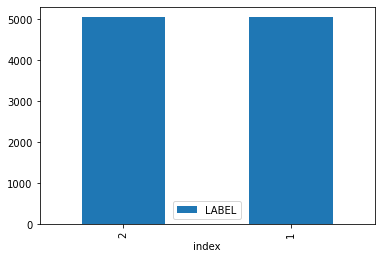

In [14]:
model = SMOTE()
x_train_res,y_train_res = model.fit_resample(train.drop('LABEL',axis=1), train['LABEL'])
y_train_res = y_train_res.astype('int')

y_train_res.value_counts().reset_index().plot(kind='bar', x='index', y='LABEL')

This removes the imbalance in the classes. The 2 classes are clearly now equal in the new training set.

### Model Training

In [21]:
%%capture
#removing the output of the reservoir iterating through the steps

#Changing how the dataset is formatted to match what the reservoir will take
#in the example on github they use a list of arrays
X_train1_res = x_train_res
n = len(X_train1_res)
X_train_res = []
for i in range(n):
    x = X_train1_res.iloc[i].to_numpy()
    X_train_res.append(x)
    
X_test1 = test
X_test1 = X_test1.drop(['LABEL'], axis = 1)
n = len(X_test1)
X_test = []
for i in range(n):
    x = X_test1.iloc[i].to_numpy()
    X_test.append(x)

Y_train1_res = y_train_res
n = len(Y_train1_res)
Y_train_res = []
for i in range(n):
    if Y_train1_res.loc[i] == 1:
        x = np.array([1,0])
        Y_train_res.append(x)
    elif Y_train1_res.loc[i] == 2:
        x = np.array([0,1])
        Y_train_res.append(x)

Y_test1 = test[['LABEL']].copy()
n = len(Y_test1)
Y_test = []
for i in range(n):
    if Y_test1.loc[i,'LABEL'] == 1:
        x = np.array([1,0])
        Y_test.append(x)
    elif Y_test1.loc[i,'LABEL'] == 2:
        x = np.array([0,1])
        Y_test.append(x)

#defining our reservoir and putting it through training and testing
source = Input()
reservoir = Reservoir(1000, sr=0.1, lr=0.5, seed = 123)
readout = Ridge(ridge=1e-6)
model = source >> reservoir >> readout

states_train = []
for x in X_train_res:
    states = reservoir.run(x, reset=True)
    states_train.append(states[-1, np.newaxis])
    
readout.fit(states_train, Y_train_res)
    
Y_pred = []
for x in X_test:
    states = reservoir.run(x, reset=True)
    y = readout.run(states[-1, np.newaxis])
    Y_pred.append(y)

### Results

In [16]:
#changing our output to a class of either [1,0] or [0,1]
Y_pred_class = [np.argmax(y_p) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t) for y_t in Y_test]
score = accuracy_score(Y_test_class, Y_pred_class)
print("Total Accuracy: ", f"{score * 100:.3f} %")

Total Accuracy:  98.246 %


Text(0.5, 1.0, 'CONFUSION MATRIX')

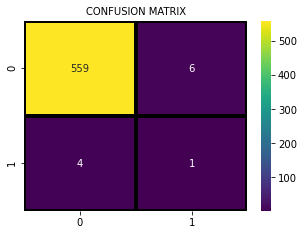

In [17]:
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix
            (Y_test_class,Y_pred_class),
            annot=True,cmap="viridis",
            fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=10)

In [29]:
from sklearn.metrics import precision_score
precision = precision_score(Y_pred_class,Y_test_class, average = 'binary')
print("Precision: ", f"{precision * 100:.3f} %")

Precision:  20.000 %


In [28]:
from sklearn.metrics import recall_score
recall = recall_score(Y_pred_class,Y_test_class, average = 'binary')
print("Recall: ", f"{recall * 100:.3f} %")

Recall:  14.286 %


In [32]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_class,Y_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       565
           1       0.14      0.20      0.17         5

    accuracy                           0.98       570
   macro avg       0.57      0.59      0.58       570
weighted avg       0.99      0.98      0.98       570

